# Assignment 4

## EOSC 510

## Andrew Loeppky

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA

## Part 0 - Get the raw data

<AxesSubplot:>

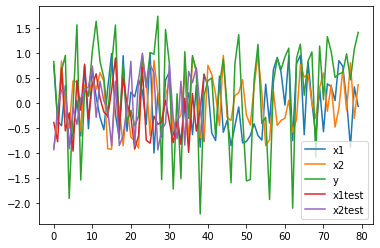

In [2]:
data = pd.read_csv("data.csv")

data.plot()

## Part 1 - Model design


In [3]:
# define RMSE as a function, since we'll use this in the NN model 
def rmse(target,prediction):
    return(np.sqrt(((target - prediction)**2).sum()/len(target)))

In [4]:
# unpack data
x1 = data["x1"]
x2 = data["x2"]
y = data["y"]
x1test = data["x1test"]
x2test = data["x2test"]

x_realtest = np.array([x1test[np.isnan(x1test) == False], x2test[np.isnan(x2test) == False]]).T


In [5]:
x_realtest

array([[-0.38910592, -0.93014859],
       [-0.77200678, -0.10926642],
       [ 0.69958288,  0.25859308],
       [-0.55692218,  0.2330141 ],
       [-0.19664864, -0.91484372],
       [-0.96141415, -0.08979249],
       [ 0.45145916, -0.42642752],
       [-0.14368763,  0.09701677],
       [ 0.77428672,  0.26443632],
       [-0.31973994,  0.32153903],
       [ 0.36404713,  0.7383502 ],
       [ 0.58218626, -0.28543239],
       [ 0.09367498,  0.43368692],
       [-0.17960958,  0.04308731],
       [-0.26236628, -0.12765205],
       [ 0.25152238, -0.85324989],
       [ 0.89680261,  0.43443795],
       [-0.54104351, -0.84871661],
       [ 0.49657928, -0.65218225],
       [-0.00371324, -0.08463106],
       [-0.27006094,  0.83236774],
       [-0.91986723, -0.85476057],
       [-0.65255051,  0.4698263 ],
       [ 0.70897009,  0.99260418],
       [-0.74398088,  0.31312853],
       [-0.80176391,  0.76213949],
       [-0.26301527,  0.6045692 ],
       [-0.42509167, -0.93540608],
       [-0.37833371,

In [6]:
# scale y on [0,1]
y-=np.min(y)
y/=np.max(y) 

In [7]:
# divide into training and validation datasets
ntrain = int(len(y) * 0.7)

# training set
x1_train = x1[:ntrain]
x2_train = x2[:ntrain]
x_train = np.array([x1_train, x2_train]).T

y_train = y[:ntrain]

# validation set
x1_test = x1[ntrain:]
x2_test = x2[ntrain:]
x_test = np.array([x1_test, x2_test]).T
y_test = y[ntrain:]

In [8]:
##### Play around with these parameters
num_models = 20 #number of models to build for the ensemble
min_nhn = 1 #minimum number of hidden neurons to loop through (nhn = 'number hidden neurons')
max_nhn = 9 #maximum number of hidden neurons to loop through
max_hidden_layers = 2 #maximum number of hidden layers to loop through (nhl = 'number hidden layers')
batch_size = 32
solver = 'adam' #use stochastic gradient descent as an optimization method (weight updating algorithm)
activation = 'relu'
learning_rate_init = 0.01
#####

max_iter = 1500 #max number of epochs to run
early_stopping = True #True = stop early if validation error begins to rise
validation_fraction = 0.1 #fraction of training data to use as validation

y_out_all_nhn = []
y_out_ensemble = []
RMSE_ensemble = [] #RMSE for each model in the ensemble
RMSE_ensemble_cumsum = [] #RMSE of the cumulative saltation for each model
nhn_best = []
nhl_best = []
##########################################################################
y_out_ensemble_real = []
y_out_all_real = []
##########################################################################

for model_num in range(num_models): #for each model in the ensemble
    
    print('Model Number: ' + str(model_num))
    
    RMSE = []
    y_out_all_nhn = []
    nhn = []
    nhl = []
    
    for num_hidden_layers in range(1,max_hidden_layers+1):
    
        print('\t # Hidden Layers = ' + str(num_hidden_layers))
    
        for num_hidden_neurons in range(min_nhn,max_nhn+1): #for each number of hidden neurons

            print('\t\t # hidden neurons = ' + str(num_hidden_neurons))
            
            hidden_layer_sizes = (num_hidden_neurons,num_hidden_layers)
            model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                                 verbose=False,
                                 max_iter=max_iter, 
                                 early_stopping = early_stopping,
                                 validation_fraction = validation_fraction,
                                 batch_size = batch_size,
                                 solver = solver,
                                 activation = activation,
                                 learning_rate_init = learning_rate_init)

            model.fit(x_train,y_train) #train the model

            y_out_this_nhn = model.predict(x_test) #model prediction for this number of hidden neurons (nhn)
            y_out_all_nhn.append(y_out_this_nhn) #store all models -- will select best one best on RMSE
            
            ###############################################################################################
            y_out_real = model.predict(x_realtest) # predict the non-training set using current model
            y_out_all_real.append(y_out_real)
            ###############################################################################################

            RMSE.append(rmse(y_test,y_out_this_nhn)) #RMSE between cumulative curves
            
            nhn.append(num_hidden_neurons)
            nhl.append(num_hidden_layers)
        
    indBest = RMSE.index(np.min(RMSE)) #index of model with lowest RMSE
    RMSE_ensemble.append(np.min(RMSE))
    nhn_best.append(nhn[indBest])
    nhl_best.append(nhl[indBest])
    #nhn_best.append(indBest+1) #the number of hidden neurons that achieved best model performance of this model iteration
    y_out_ensemble.append(y_out_all_nhn[indBest])
    ###############################################
    y_out_ensemble_real.append(y_out_all_real[indBest])
    ###############################################
    print('\t BEST: ' + str(nhl_best[model_num]) + ' hidden layers, '+ str(nhn_best[model_num]) + ' hidden neurons')
    
y_out_ensemble_mean = np.mean(y_out_ensemble,axis=0)
####################################################
y_real_ensemble_mean = np.mean(y_out_ensemble_real,axis=0)
####################################################
RMSE_ensemble_mean = rmse(y_out_ensemble_mean,y_test)

Model Number: 0
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
	 BEST: 2 hidden layers, 6 hidden neurons
Model Number: 1
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 

		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
	 BEST: 2 hidden layers, 3 hidden neurons
Model Number: 16
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
	 BEST: 2 hidden layers, 6 hidden neurons
Model Number: 17
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		

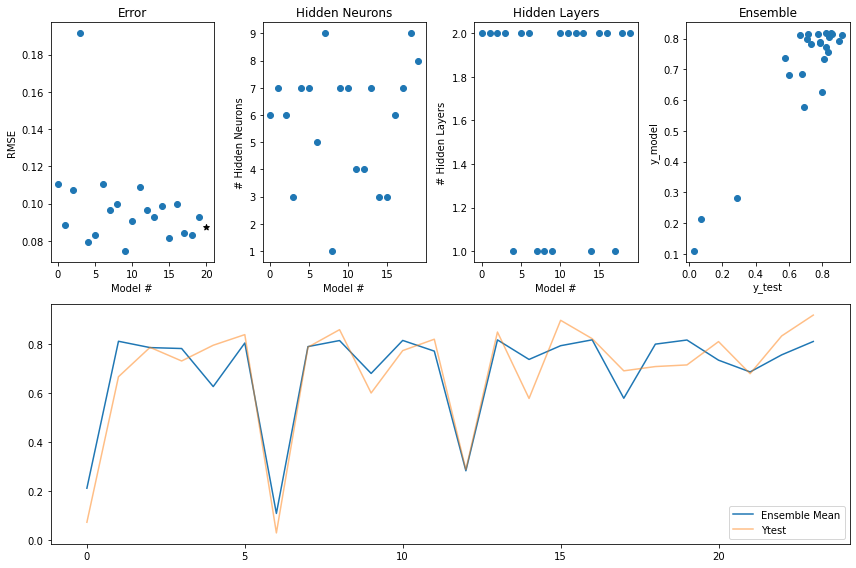

In [9]:
#visualize

plt.figure(figsize=(12,8))

plt.subplot(241)
plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*')
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble)
plt.xlabel('Model #')
plt.ylabel('RMSE')
plt.title('Error')

plt.subplot(242)
plt.scatter(range(len(nhn_best)),nhn_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Neurons')
plt.title('Hidden Neurons')

plt.subplot(243)
plt.scatter(range(len(nhl_best)),nhl_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Layers')
plt.title('Hidden Layers')

plt.subplot(244)
plt.scatter(y_test,y_out_ensemble_mean)
#plt.plot((np.min(y_test),np.max(y_test)),'k--')
plt.xlabel('y_test')
plt.ylabel('y_model')
plt.title('Ensemble')

plt.subplot(212)
plt.plot(y_out_ensemble_mean, label="Ensemble Mean")
plt.plot(np.array(y_test),alpha = 0.5, label="Ytest")
plt.legend()

plt.tight_layout()

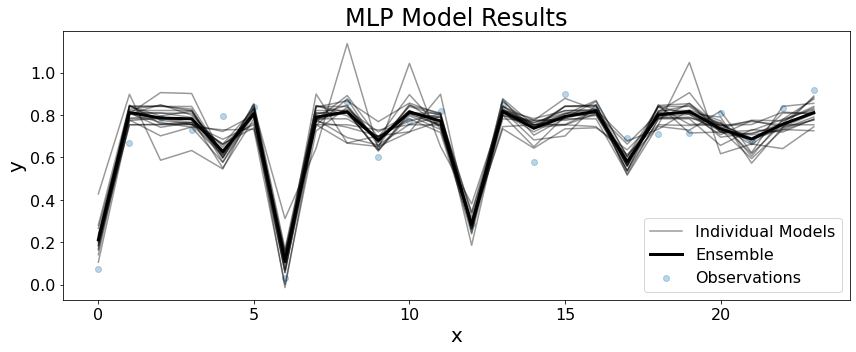

In [21]:
#visualize individual model runs

saveIt = 0

plt.figure(figsize = (12,5))

plt.scatter(range(len(y_test)),y_test,label='Observations',zorder = 0,alpha = 0.3)
plt.plot(range(len(y_test)),np.transpose(y_out_ensemble[0]),color = 'k',alpha = 0.4,label='Individual Models',zorder=1) #plot first ensemble member with a label
plt.plot(range(len(y_test)),np.transpose(y_out_ensemble[1:]),color = 'k',alpha = 0.4,zorder=1) #plot remaining ensemble members without labels for a nicer legend
plt.plot(range(len(y_test)),y_out_ensemble_mean,color = 'k',label = 'Ensemble',zorder=2, linewidth = 3)
plt.xlabel("x", fontsize = 20)
plt.ylabel('y', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('MLP Model Results', fontsize = 24)
plt.legend(fontsize = 16, loc = 'best')

plt.tight_layout()

if saveIt:
    plt.savefig('tutorial10_fig12.png')

plt.show()

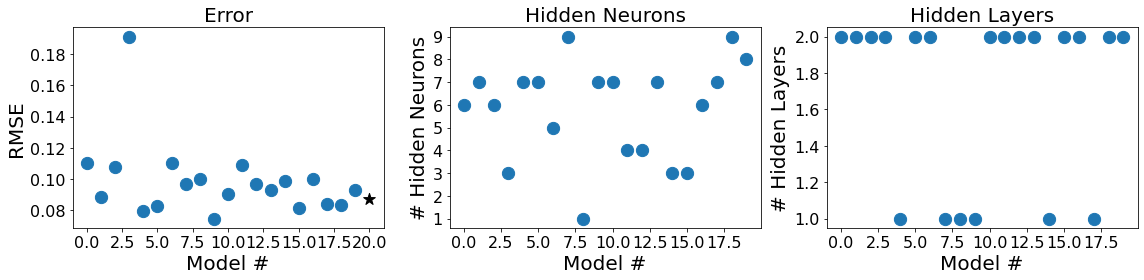

In [11]:
#visualize performance metrics/etc

saveIt = 0

plt.figure(figsize=(16,4))

plt.subplot(131)
plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*', s = 150)
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble, s = 150)
#plt.axhline(np.mean(RMSE_ensemble), color="r", alpha=0.5, linestyle=":")
plt.xlabel('Model #', fontsize = 20)
plt.ylabel('RMSE', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
#plt.ylim((np.min(RMSE_ensemble) - 0.005, np.max(RMSE_ensemble)+0.005))
plt.title('Error', fontsize = 20)

plt.subplot(132)
plt.scatter(range(len(nhn_best)),nhn_best, s = 150)
plt.xlabel('Model #', fontsize = 20)
plt.ylabel('# Hidden Neurons', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Hidden Neurons', fontsize = 20)

plt.subplot(133)
plt.scatter(range(len(nhl_best)),nhl_best, s = 150)
plt.xlabel('Model #', fontsize = 20)
plt.ylabel('# Hidden Layers', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Hidden Layers', fontsize = 20)

plt.tight_layout()

if saveIt:
    plt.savefig('tutorial10_fig10.png')
    
plt.show()

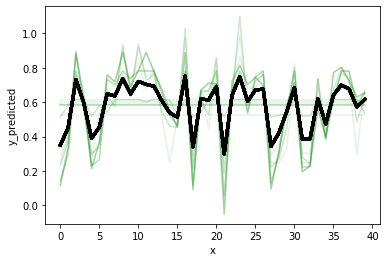

In [22]:
for i in range(np.shape(y_out_ensemble_real)[0]):
    plt.plot(y_out_ensemble_real[i], 'g', alpha=0.1)
    plt.plot(y_real_ensemble_mean, linewidth=3, color='k')
plt.xlabel("x")
plt.ylabel("y_predicted");

In [46]:
x1test_out = data["x1test"][np.isnan(data["x1test"]) == False]
x2test_out = data["x2test"][np.isnan(data["x2test"]) == False]

data_out = pd.DataFrame(
    np.array([y_real_ensemble_mean, x1test_out, x2test_out]).T,
    columns=["y_predicted", "x1test", "x2test"],
)
data_out.to_csv("./loeppky_ast4result.csv")